Testing the implementaion of All positive values using 7 Qubits - 128 data points

The experimental code for developing Amplitude embedded circuits using Variational Quantum State Preparation (VQSP). The VQSP algorithm uses PQC to create training circuits which learns the parameters to create the corresponding amplitude embedded states.

In [1]:
# !pip install pennylane nftopt

We specify the number of qubits needed to map the data, for n qubits we can amplitude embedded 2^n data. The depth represents the ansatz repitition depth.

In [2]:
#defining parameters
n_qubits = 7
depth = 4

Generating Random data points to be amplitude embedded.

In [3]:
import numpy as np
total_val = 2**n_qubits
arr = np.random.rand(1,total_val)
print(arr)

[[0.32990819 0.14086813 0.46292175 0.91836203 0.64823924 0.75982963
  0.45300365 0.6045035  0.82465655 0.73482226 0.54968708 0.65319165
  0.56755442 0.60308675 0.16438858 0.98039736 0.15821722 0.3411931
  0.94042343 0.23328886 0.29360192 0.5648346  0.484904   0.34894405
  0.53648153 0.02609374 0.84042143 0.11783411 0.12398401 0.48125641
  0.16922035 0.66798298 0.08496577 0.8431399  0.82213477 0.77597262
  0.20022907 0.64356786 0.80097945 0.75571026 0.79701273 0.85192739
  0.94217201 0.4894664  0.29572423 0.66628439 0.03343879 0.76528132
  0.99155013 0.36559806 0.59176018 0.6192578  0.37470952 0.9621501
  0.83260983 0.47376939 0.17156849 0.82264579 0.367574   0.36107849
  0.10328958 0.51292685 0.43329879 0.17019758 0.00282529 0.47098967
  0.92748668 0.51319514 0.53310128 0.59955547 0.84504188 0.66307177
  0.64160319 0.5058734  0.08817263 0.31758761 0.78973505 0.73398316
  0.20618146 0.47050429 0.51194178 0.41216325 0.58616496 0.91471674
  0.82684042 0.05728719 0.42176619 0.78855271 0.38

Normalizing the points by dividing by their sum

In [4]:
summer = np.sum(arr)
print(summer)
normalized_X = arr/summer
print(normalized_X)

64.98363088336498
[[5.07678908e-03 2.16774783e-03 7.12366700e-03 1.41322056e-02
  9.97542356e-03 1.16926312e-02 6.97104243e-03 9.30239652e-03
  1.26902196e-02 1.13078055e-02 8.45885455e-03 1.00516337e-02
  8.73380591e-03 9.28059486e-03 2.52969210e-03 1.50868357e-02
  2.43472415e-03 5.25044683e-03 1.44716972e-02 3.58996341e-03
  4.51809042e-03 8.69195196e-03 7.46194075e-03 5.36972233e-03
  8.25564111e-03 4.01543312e-04 1.29328174e-02 1.81328905e-03
  1.90792678e-03 7.40580980e-03 2.60404571e-03 1.02792499e-02
  1.30749494e-03 1.29746506e-02 1.26514133e-02 1.19410475e-02
  3.08122320e-03 9.90353810e-03 1.23258648e-02 1.16292403e-02
  1.22648231e-02 1.31098767e-02 1.44986052e-02 7.53214910e-03
  4.55074958e-03 1.02531111e-02 5.14572540e-04 1.17765245e-02
  1.52584600e-02 5.62600229e-03 9.10629597e-03 9.52944283e-03
  5.76621400e-03 1.48060379e-02 1.28126086e-02 7.29059587e-03
  2.64018012e-03 1.26592770e-02 5.65640907e-03 5.55645297e-03
  1.58947071e-03 7.89317005e-03 6.66781438e-03 2.619

In [5]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from scipy import optimize
from nftopt import nakanishi_fujii_todo as nftmethod

Lightning.GPU device has been used to work on NVIDIA GPU powerups

In [6]:
dev = qml.device('lightning.gpu',wires=n_qubits)
dev

<LightningGPU device (wires=7, shots=None) at 0x7f306831ed40>

A single Ansatz layer used for training contains set of trainiable RY gates for all the qubits followed by cyclic CZ arrangement.

In [7]:
def ansatz_layer(layer_weights, depth, n_qubits):
    for dep in range(depth):
        for wire in range(n_qubits):
            qml.RY(layer_weights[wire+(n_qubits*dep)], wires=wire)

        for i in range(n_qubits-1):
            qml.CZ(wires=[i,i+1])
        qml.CZ(wires=[n_qubits-1,0])

We use the Fidelity as the accuracy metric in this case. The Fidelity estimate provides the similarity between the generated state and the required amplitude embedding. It returs 1 if there are similar.

In [8]:
def accuracy(labels, predictions):
  state0 = qml.math.dm_from_state_vector(labels)
  state1 = qml.math.dm_from_state_vector(predictions)
  return qml.math.fidelity(state0, state1)

In [9]:
@qml.qnode(dev)
def circuit(weights):
  # since depth 4 was used
  ansatz_layer(weights,depth=depth, n_qubits=n_qubits)
  # qml.state() applies Ua to Ini State, which gives Appro_a
  return qml.state()

In [10]:
def variational_classifier(weights, x):
    # weights are thetas
    return np.real(circuit(weights))

We convert the data into a state representation by dividing them with their squre root of sum so as to obtain the probability value of the state vector as 1.

In [11]:
temp = []
for i in range(len(normalized_X[0])):
  temp.append(np.sqrt(normalized_X[0][i]))
x = np.array(temp)
print(x)

[0.07125159 0.04655908 0.08440182 0.11887895 0.09987704 0.10813247
 0.08349277 0.09644893 0.11265087 0.10633817 0.09197203 0.10025784
 0.09345483 0.09633584 0.05029604 0.12282848 0.04934292 0.07245997
 0.12029837 0.0599163  0.06721674 0.09323064 0.08638253 0.07327839
 0.09086056 0.02003855 0.11372255 0.04258273 0.04367982 0.08605701
 0.05102985 0.10138664 0.0361593  0.11390632 0.1124785  0.1092751
 0.05550877 0.09951652 0.11102191 0.10783896 0.11074666 0.11449837
 0.12041015 0.08678795 0.06745924 0.10125765 0.02268419 0.1085197
 0.12352514 0.07500668 0.09542691 0.09761887 0.07593559 0.12168006
 0.11319279 0.08538499 0.05138268 0.11251345 0.0752091  0.07454162
 0.03986817 0.08884351 0.08165669 0.05117699 0.0065937  0.08513413
 0.11946807 0.08886675 0.09057386 0.09605339 0.11403473 0.10101324
 0.0993645  0.08823054 0.03683536 0.06990847 0.11023988 0.10627743
 0.0563278  0.08509025 0.08875816 0.07964026 0.0949747  0.11864278
 0.11279994 0.02969113 0.08056268 0.11015732 0.07728084 0.044273

This calculates the total probability value of the state and it's 1.

In [12]:
sum = 0
for i in range(len(x)):
  sum += x[i]**2
print(sum)

1.0


The Cost function for Approach 1 from the paper <a>https://arxiv.org/pdf/2302.13299.pdf</a>. This cost function can only be used for All positive or All negative data values.

In [13]:
def F1_loss(a,Appro_a):
  #   Define the cost function
  F1 = 0.
  length = 2**n_qubits
  for i in range(length):
    F1 += (a[i]**2)*np.log2((Appro_a[i]**2)/(a[i]**2))
      
  #   Prepare the Bell state
  states = 2**n_qubits
  Bell_State=np.ones((states,1))/np.linalg.norm(np.ones((states,1)))
  #   The sum of vector a
  Sum_a=np.sum(a)
  sqrt_D = np.linalg.norm(np.ones((states,1)))
  UaFunction=np.abs(Sum_a -  (sqrt_D * np.matmul(np.transpose(Bell_State), Appro_a)))-(F1)
  return np.real(UaFunction)

In [14]:
cost_values = []
def cost(weights, X=x):
    # X is our preparation state
    Appro_a = variational_classifier(weights, X)
    expectation_value = F1_loss(X, Appro_a)
    cost_values.append(expectation_value)
    return expectation_value

We perform the minimization using the Nakanishi-Fujii-Todo algorithm. 

In [15]:
import time
weights = 4*np.pi*np.random.rand(n_qubits * depth)
start = time.time()
result= optimize.minimize(cost,weights, method=nftmethod, options={'maxfev':5000})
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 105.44137144088745s


The final sets of weights after performin optimization. These can be used to the generate the requried amplitude embedded state.

In [16]:
result.x

array([ 3.09501292, 11.08869078, 15.70153603,  3.2235248 ,  2.47789243,
       -0.11009238,  4.75014844,  3.12644818,  4.75012514,  9.88921019,
        9.41677586,  8.87788541,  6.37164483,  2.80841756,  7.8273322 ,
        1.41455215,  2.12192669,  4.58754238,  7.67421136,  4.80495844,
        3.49971165, -0.04535396, -0.03910277,  9.42823648,  3.15551482,
        3.18685418, 12.59408296,  0.05802119])

We compite the fidelity of the generated states using VQSP and the original amplitude embedding needed.

In [17]:
predictions=variational_classifier(result.x,x)
acc = accuracy(x, predictions)
# print(predictions.numpy(), x.numpy())
print(acc)

0.912511422288056


In [18]:
plotting_values = []
for i in range(len(cost_values)):
    val = cost_values[i].numpy()
    plotting_values.append(val)

Text(0, 0.5, 'Cost Value')

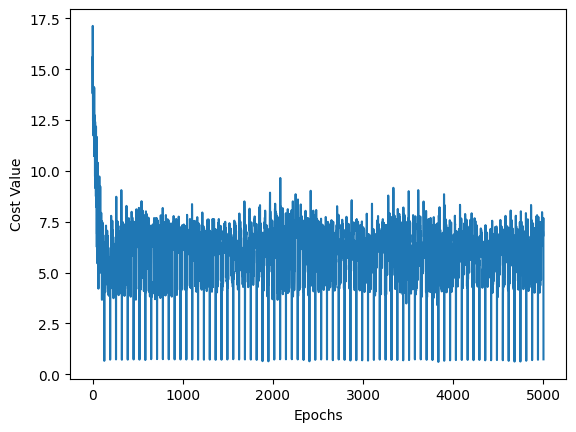

In [19]:
# Plotting how the value of the cost function decreases during the minimization procedure.
import matplotlib.pyplot as plt

x_values = list(range(len(plotting_values)))
y_values = plotting_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")

In [20]:
specs_func = qml.specs(circuit)
specs_func(result.x)

{'resources': Resources(num_wires=7, num_gates=56, gate_types=defaultdict(<class 'int'>, {'RY': 28, 'CZ': 28}), gate_sizes=defaultdict(<class 'int'>, {1: 28, 2: 28}), depth=32, shots=Shots(total_shots=None, shot_vector=())),
 'num_observables': 1,
 'num_diagonalizing_gates': 0,
 'num_trainable_params': 0,
 'num_device_wires': 7,
 'device_name': 'lightning.gpu',
 'expansion_strategy': 'gradient',
 'gradient_options': {},
 'interface': 'auto',
 'diff_method': 'best',
 'gradient_fn': 'pennylane.gradients.parameter_shift.param_shift',
 'num_gradient_executions': 'NotSupported: Computing the gradient of circuits that return the state with the parameter-shift rule gradient transform is not supported, as it is a hardware-compatible method.'}

In [21]:
np.savetxt('7_qubit_data.out', x, delimiter=',')   # X is an array

In [22]:
value = np.loadtxt('7_qubit_data.out')
print(value)

[0.07125159 0.04655908 0.08440182 0.11887895 0.09987704 0.10813247
 0.08349277 0.09644893 0.11265087 0.10633817 0.09197203 0.10025784
 0.09345483 0.09633584 0.05029604 0.12282848 0.04934292 0.07245997
 0.12029837 0.0599163  0.06721674 0.09323064 0.08638253 0.07327839
 0.09086056 0.02003855 0.11372255 0.04258273 0.04367982 0.08605701
 0.05102985 0.10138664 0.0361593  0.11390632 0.1124785  0.1092751
 0.05550877 0.09951652 0.11102191 0.10783896 0.11074666 0.11449837
 0.12041015 0.08678795 0.06745924 0.10125765 0.02268419 0.1085197
 0.12352514 0.07500668 0.09542691 0.09761887 0.07593559 0.12168006
 0.11319279 0.08538499 0.05138268 0.11251345 0.0752091  0.07454162
 0.03986817 0.08884351 0.08165669 0.05117699 0.0065937  0.08513413
 0.11946807 0.08886675 0.09057386 0.09605339 0.11403473 0.10101324
 0.0993645  0.08823054 0.03683536 0.06990847 0.11023988 0.10627743
 0.0563278  0.08509025 0.08875816 0.07964026 0.0949747  0.11864278
 0.11279994 0.02969113 0.08056268 0.11015732 0.07728084 0.044273

In [23]:
np.savetxt('7_qubit_weights.out', result.x, delimiter=',')   # weights is an array